In [2]:
import pandas as pd
import numpy as np
import mlflow

from mlflow.models.signature import infer_signature#
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    fbeta_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    auc,
    brier_score_loss,
)


from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
experiment_name = f"/cancer_classification_training"
run_name = "cancer_classification_training" + str(pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))
full_model_name = "cancer_classification_model"

LABEL = "Target"

In [4]:
# defining these up front to make mlflow experiments optional
mlflow_metrics = {} # a place to pop new metrics into
mlflow_figures = {} # a place to pop new matplotlib/sns figures into
mlflow_tables = {} # a place to pop new dataframes into (keep it small!)
mlflow_artifact_paths = []

In [5]:
def push_metric(metric_name: str, metric_value: any) -> None:
    print(f"Adding metric {metric_name}: {metric_value}")
    mlflow_metrics[metric_name] = metric_value

def push_figure(figure_name: str, figure_value: any):
    print(f"Adding figure {figure_name}: {figure_value}")
    mlflow_figures[figure_name] = figure_value

def push_table(table_name: str, table_value: any):
    print(f"Adding table {table_name}: {table_value}")
    mlflow_tables[table_name] = table_value

def push_artifact(file_path: str):
    print(f"Adding artifact {file_path}")
    mlflow_artifact_paths.append(file_path)

In [6]:
#Get clean data

def get_clean_data(filename: str) -> pd.DataFrame:
    # Load the dataset
    data = pd.read_csv(filename)
    return data


def get_train_data(data: pd.DataFrame):
    """Get training data from the cleaned dataset."""
    # Split the data into features and Target
    X = data
    y = data['Target']

    # Split the data into training and testing sets
    # Stratify to ensure both classes are represented in train/test splits
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    train_ds, val_ds = train_test_split(
        X_train, test_size=0.1, random_state=20000, shuffle=True
    )
    X_train = X_train.drop(columns=['Target'])
    X_val = val_ds.drop(columns=['Target'])
    X_test = X_test.drop(columns=['Target'])
    y_val = val_ds['Target']
     


    return X_train, X_test, y_train, y_test, X_val, y_val

In [7]:
# Define the model metrics

def calculate_metrics(y_true, y_pred, y_proba):
    """Calculate model metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)

    return accuracy, precision, recall, f1, logloss

In [8]:
def get_model_metrics(
    model: lgb.Booster, X_test: pd.DataFrame, y_test: pd.Series
) -> dict:
    y_pred_probablity = model.predict(X_test)
    pred_threshold = np.percentile(y_pred_probablity, 60)
    y_pred_label = np.where(y_pred_probablity >= pred_threshold, 1, 0)

    metrics = {
        "logloss": log_loss(y_test, y_pred_probablity),
        "pred_threshold": pred_threshold,
        "accuracy": accuracy_score(y_test, y_pred_label),        
        "f1_score": f1_score(y_test, y_pred_label),
        "f05_score": fbeta_score(y_test, y_pred_label, beta=0.5),
        "precision_score": precision_score(y_test, y_pred_label),
        "recall_score": recall_score(y_test, y_pred_label),
        "roc_auc_score": roc_auc_score(y_test, y_pred_probablity),
        "y_real_mean": y_test.mean(),
        "y_pred_mean": y_pred_probablity.mean(),
        "iterations": model.current_iteration(),
    }
    return metrics

In [9]:
mlflow.set_registry_uri("databricks-uc")
mlflow.set_experiment(experiment_name)
run = mlflow.start_run(run_name=run_name, description=f"Building a model for {experiment_name}")
print(f"creating run called {run.info.run_name}")

2025/06/19 13:50:07 INFO mlflow.tracking.fluent: Experiment with name '/cancer_classification_training' does not exist. Creating a new experiment.


creating run called cancer_classification_training2025-06-19 13:50:07


In [10]:
clean_df = get_clean_data('../data/clean.csv')
push_metric("count_initial", clean_df.shape[0])

Adding metric count_initial: 104


In [11]:
X_train, X_test, Y_train, Y_test, X_val, Y_val = get_train_data(clean_df)


In [12]:
unsupported_cols = X_train.select_dtypes(exclude=['int', 'float', 'bool']).columns
print("Columns with unsupported data types:", unsupported_cols)

Columns with unsupported data types: Index([], dtype='object')


In [13]:
evals_result = {}

In [14]:
def eval_logloss(y_hat, data):
    y_true = data.get_label()
    return "logloss", log_loss(y_true, y_hat), False

In [15]:

# Define constants
PRIMARY_METRIC = "logloss"  # or "f1"
ESTIMATORS = 50 
EARLY_STOP = 5
LEARNING_RATE = 0.045
CATEGORICAL_FEATURES = []
# Prepare datasets
# Assuming X_train, y_train, X_valid, y_valid are predefined
lgb_train_final = lgb.Dataset(
    X_train,
    label=Y_train,
    feature_name=list(X_train.columns),
    categorical_feature=CATEGORICAL_FEATURES
)

lgb_valid = lgb.Dataset(X_val, label=Y_val, reference=lgb_train_final)

# lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train_final)

# Define parameters
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": PRIMARY_METRIC,
    "num_threads": 16,
    "learning_rate": LEARNING_RATE,
}

# Define callbacks
callbacks = [
    lgb.early_stopping(stopping_rounds=EARLY_STOP),
    lgb.log_evaluation(period=10),  # Adjust the period as needed
]

final_model = lgb.train(
    params=params,
    train_set=lgb_train_final,
    valid_sets=lgb_valid, 
    num_boost_round=ESTIMATORS,
    feval=eval_logloss,
    callbacks=callbacks
)

print("Final model built")

[LightGBM] [Info] Number of positive: 46, number of negative: 37
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554217 -> initscore=0.217723
[LightGBM] [Info] Start training from score 0.217723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [16]:
metrics = get_model_metrics(
    final_model, X_test, Y_test)


In [17]:
for (metric_name, metric_value) in metrics.items():
    push_metric(metric_name, metric_value)

Adding metric logloss: 0.6048709334528038
Adding metric pred_threshold: 0.6089957540078546
Adding metric accuracy: 0.5714285714285714
Adding metric f1_score: 0.5714285714285714
Adding metric f05_score: 0.625
Adding metric precision_score: 0.6666666666666666
Adding metric recall_score: 0.5
Adding metric roc_auc_score: 0.7222222222222223
Adding metric y_real_mean: 0.5714285714285714
Adding metric y_pred_mean: 0.5399377928864484
Adding metric iterations: 50


Plot: Receiver Operating Characteristic (ROC) Curve

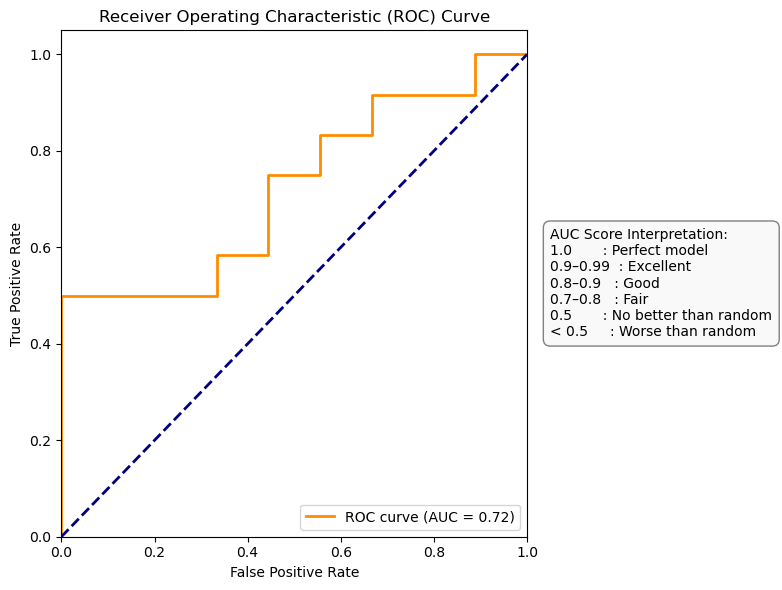

Adding figure receiver_operating_characteristic.png: Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [ ]:

y_pred_proba = final_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

auc_legend = (
    "AUC Score Interpretation:\n"
    "1.0       : Perfect model\n"
    "0.9–0.99  : Excellent\n"
    "0.8–0.9   : Good\n"
    "0.7–0.8   : Fair\n"
    "0.5       : No better than random\n"
    "< 0.5     : Worse than random"
)
plt.gca().text(
    1.05, 0.5, auc_legend,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='center',
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="gray", facecolor="#f9f9f9")
)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

push_figure("receiver_operating_characteristic.png", plt.gcf())

### Plot: Kernel Density Estimate (KDE)

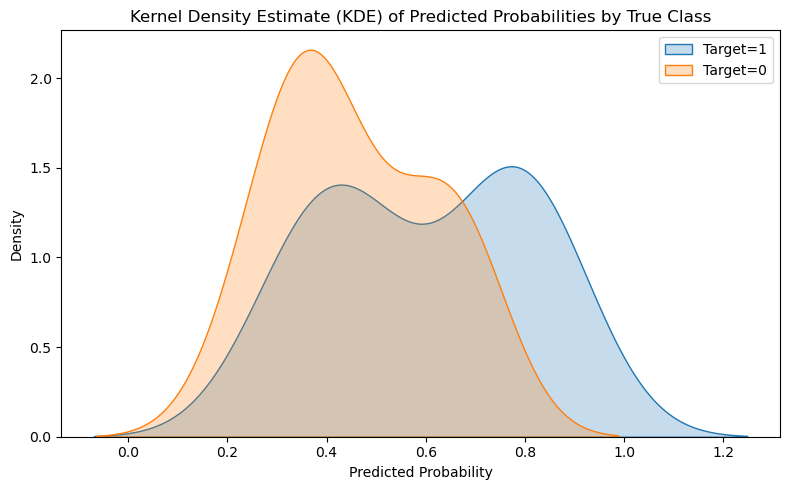

Adding figure kde_plot.png: Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 5))
for label in Y_test.unique():
    subset = final_model.predict(X_test[Y_test == label])
    sns.kdeplot(subset, label=f"Target={label}", fill=True)
plt.title("Kernel Density Estimate (KDE) of Predicted Probabilities by True Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

push_figure("kde_plot.png", plt.gcf())

Plot: Confusion Matrix

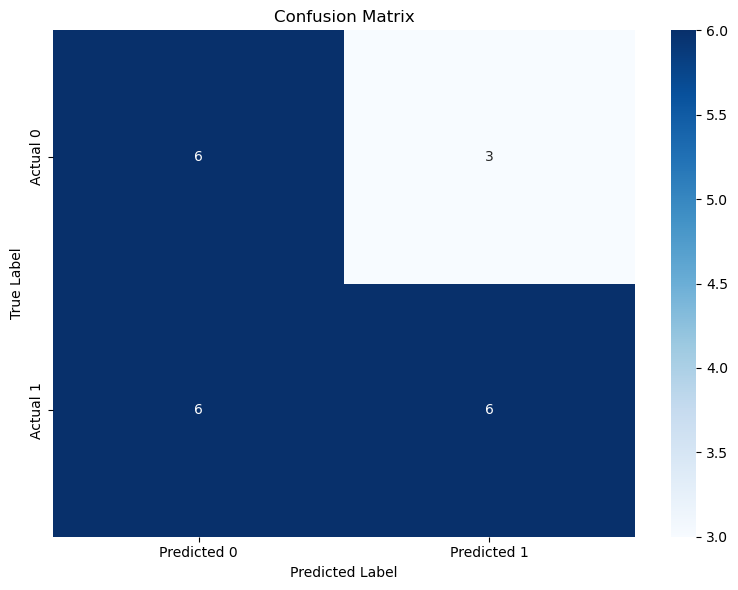

Adding figure confusion_matrix.png: Figure(640x480)


<Figure size 640x480 with 0 Axes>

In [23]:

conf_matrix = confusion_matrix(Y_test, np.where(y_pred_proba >= metrics["pred_threshold"], 1, 0))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

plt.show()

push_figure("confusion_matrix.png", plt.gcf())


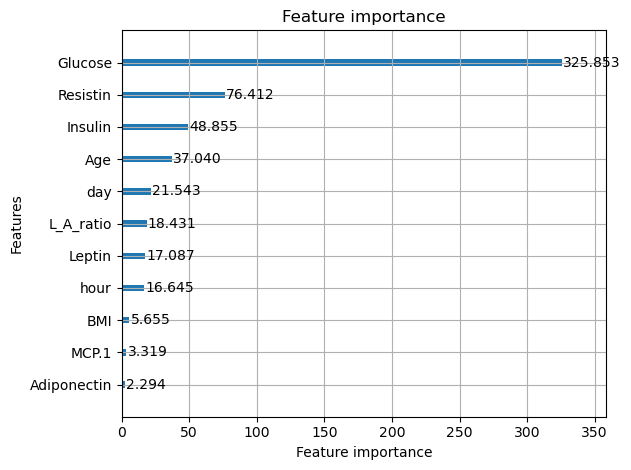

Adding figure feature_importance_gain.png: Figure(640x480)


In [21]:
ax_importance_gain = lgb.plot_importance(final_model, max_num_features=50, importance_type="gain")
ax_importance_gain.figure.tight_layout()
plt.show()

push_figure("feature_importance_gain.png", ax_importance_gain.figure)

In [22]:
print(f"registering model as: {full_model_name}")
autolog_run = mlflow.last_active_run()
model_uri = "runs:/{}/models/final_model".format(autolog_run.info.run_id)

# create a signature for the model so that mlflow knows the inputs and outputs (we need this because we're not using mlflow.autolog)
X_train_sample = pd.DataFrame(X_train[:10], columns=X_train.columns)
signature = infer_signature(X_train_sample, final_model.predict(X_train_sample))

mlflow.lightgbm.log_model(
    final_model,
    registered_model_name=full_model_name,
    signature=signature
)
# this simply logs metadata about the dataset (not the data itself)
mlflow.log_input(mlflow.data.from_pandas(X_test), context="test")
mlflow.log_input(mlflow.data.from_pandas(X_train), context="train")

registering model as: cancer_classification_model


c:\Users\kayewan\.conda\envs\cancer_classifier_env\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


MlflowException: Reading Databricks credential configuration failed with MLflow registry URI 'databricks-uc'. Please ensure that the 'databricks-sdk' PyPI library is installed, the tracking URI is set correctly, and Databricks authentication is properly configured. The registry URI can be either 'databricks-uc' (using profile name specified by 'DATABRICKS_CONFIG_PROFILE' environment variable or using 'DEFAULT' authentication profile if 'DATABRICKS_CONFIG_PROFILE' environment variable does not exist) or 'databricks-uc://{profile}'. You can configure Databricks authentication in several ways, for example by specifying environment variables (e.g. DATABRICKS_HOST + DATABRICKS_TOKEN) or logging in using 'databricks auth login'. 
For details on configuring Databricks authentication, please refer to 'https://docs.databricks.com/en/dev-tools/auth/index.html#unified-auth'.

In [0]:
if mlflow.active_run() == None:
    raise Exception("A DrAI run hasn't been started, guessing you don't want a partially complete experiment")

# ADD other metrics
for (metric_name, metric_value) in mlflow_metrics.items():
    print(f"logging other metric: {metric_name}=metric_value")
    mlflow.log_metric(metric_name, metric_value)

for (figure_name, figure) in mlflow_figures.items():
    print(f"logging figure: {figure_name}")
    mlflow.log_figure(figure, figure_name)

for (table_name, table_df) in mlflow_tables.items():
    print(f"logging table: {table_name}")
    mlflow.log_table(table_df, table_name)

In [ ]:
mlflow.end_run()